In [4]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display
import urllib
import json
import os, glob
from IPython.core.display import display, HTML
import logging
import pandas as pd

import warpImage
from pointAnnotator import pointAnnotator, pointCopier, points_from_path
# try:
#     import config as cfg
#     print('loaded device specific config')
# except ImportError as E:
import default_config as cfg
print('loaded default config')



display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib notebook

logging.basicConfig(level=logging.INFO)

loaded default config


In [5]:
localWarp=False

#for some reason, I find you have to run this line twice to actually take effect (depending on matplotlib version)
%matplotlib notebook 

In [40]:
#### get path to network folder with lims images for this mouse
mouse_num = '521466'
desired_image_filenames_contain = ['surface-image100']
json_string = urllib.urlopen("http://lims2/specimens/isi_experiment_details/" + mouse_num + ".json").read()
info = json.loads(json_string)
#print(info)

####################it looks like it always pulls the map with targets on it but what happens if two have targets?
vimg_path = r'\\' + info[0]['target_map_image_path'][1:]
#experiments = info[0]['isi_experiments']
#for exp in experiments:
#    if exp['targets']['insertion_targets']['reticle_space'] is not None:
#        pass

logging.info(vimg_path)

#get vasculature image
vimg = cv2.imread(vimg_path)

#get probe insertion image
pimgFileList = []#[r"Z:\03132019_416656\2019_03_13_15_11_10_left.png"]
if len(pimgFileList) == 0:
    pimgFileList = cfg.get_insertion_image_paths(mouse_num, desired_image_filenames_contain=desired_image_filenames_contain)
    
canidate_image_count = len(pimgFileList)

pimg_dict = {}
ppa_dict = {}
points_dict = {}


if canidate_image_count > 1:
    fig, ax = plt.subplots(canidate_image_count, figsize=(20,20))#/(2*aspect)))
    for idx, image_path in enumerate(pimgFileList):
        next_ax = ax[idx]
        logging.info(image_path)
        next_image = cv2.imread(image_path)
        next_image = next_image[:, :, [2,1,0]]
        pimg_dict[image_path] = next_ax.imshow(next_image, origin='upper')
        ppa_dict[image_path] = pointAnnotator(pimg_dict[image_path], next_ax)
        directory_path, image_name = os.path.split(image_path)
        points_dict[image_path] = points_from_path(directory_path, image_name, 'landmark_points')
        ppa_dict[image_path].loadPoints(points_dict[image_path])


INFO:root:\\allen/programs/braintv/production/visualbehavior/prod0/specimen_1022743371/isi_experiment_1024931669/1024931669_target_map.tif


INFO:root:1


521466


<IPython.core.display.Javascript object>


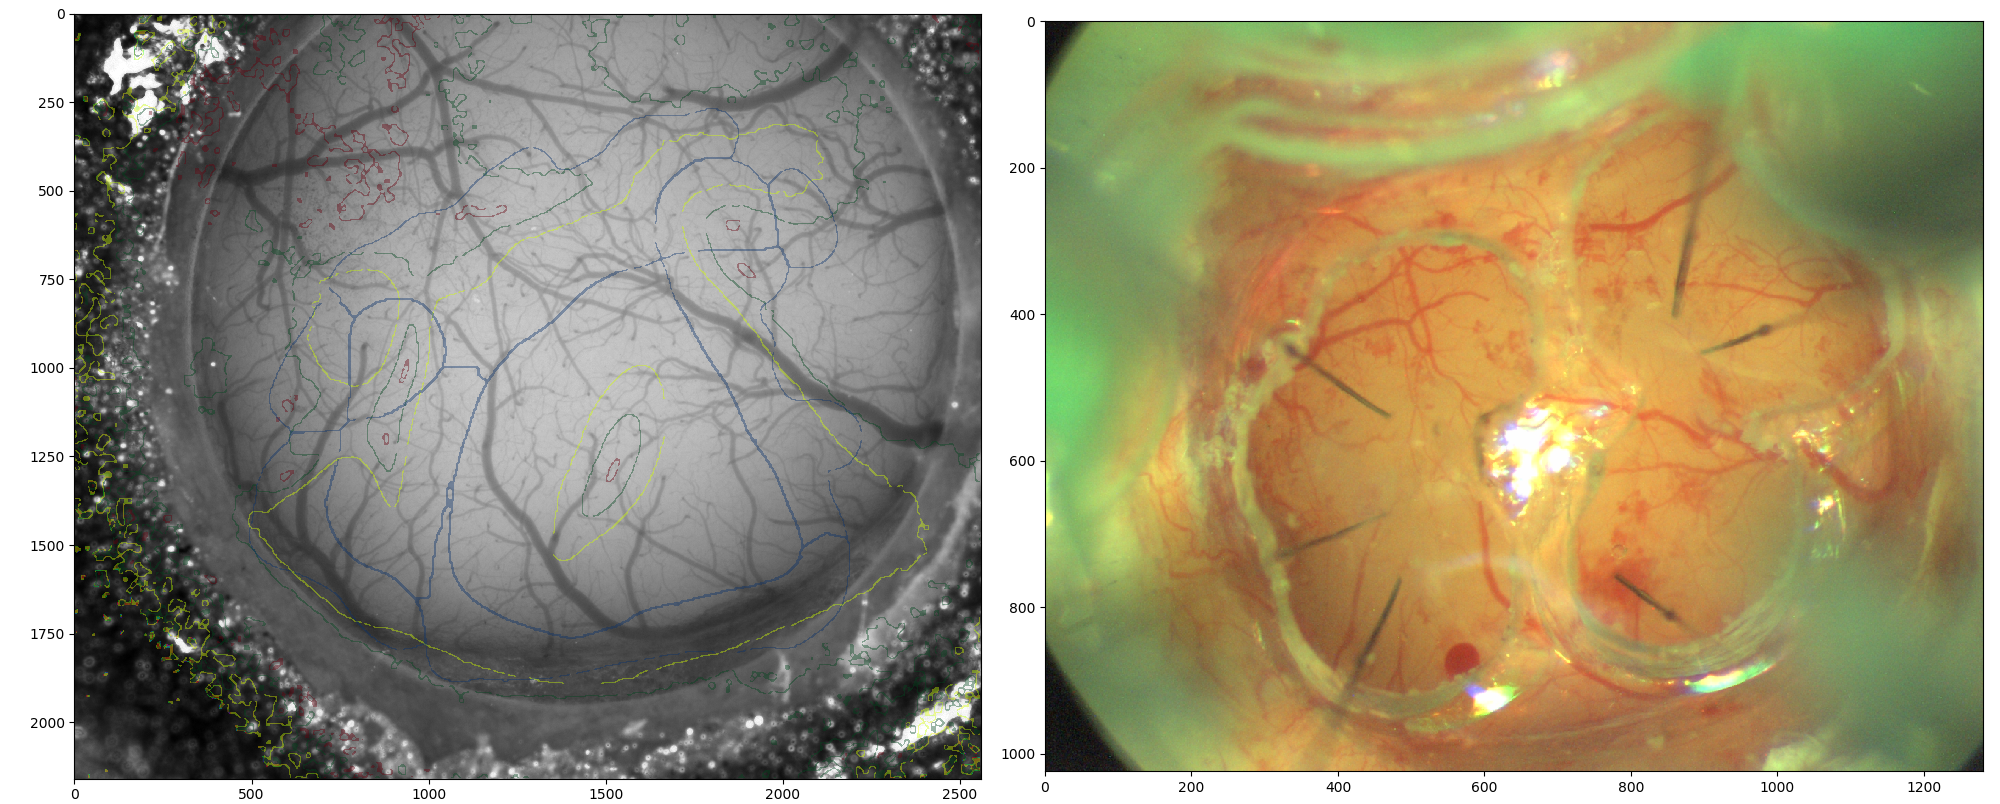

INFO:root:Found some points


In [11]:
print(mouse_num)
#Display the vasculature images and select points of interest (at least three)

use_day1_insertion_image_as_fiducial = False


if canidate_image_count > 1:
    count = 0
    for image_path, annotator in ppa_dict.items():
        if not(np.array_equal(annotator.points, points_dict[image_path])):
            count+=1
            logging.info(count)
            chosen_image_path = image_path
    try:
        assert(count==1)
    except AssertionError as E:
        logging.error('Image chosen is ambiguous, none or multiple were clicked. Please reset and try again.')
        raise(E)
    pimg_path = chosen_image_path
else:
    pimg_path = pimgFileList[0]

pimg = cv2.imread(pimg_path)
chosen_probe_image_name = os.path.split(pimg_path)[1]
chosen_vasculature_image_name = os.path.split(vimg_path)[1]

#change from opencv bgr default back to rgb
pimg = pimg[:, :, [2,1,0]]
vimg = vimg[:, :, [2,1,0]]
aspect = (pimg.shape[0]+vimg.shape[0])/float(np.max([pimg.shape[1], vimg.shape[1]]))

fiducial_fig, fiducial_ax = plt.subplots(1,2, figsize=(20,20/(2*aspect)))
vax = fiducial_ax[0]
pax = fiducial_ax[1]

if use_day1_insertion_image_as_fiducial:
    fiducial_image = cfg.get_warped_image_from_day1(pimg_path)
    #fiducial_image = PATH_TO_DAY1_WARPED_IMAGE
else:
    fiducial_image = vimg
    
vim = vax.imshow(fiducial_image, origin='upper')
vpa = pointAnnotator(vim, vax)
vasculature_landmark_points = points_from_path(pimg_path, chosen_vasculature_image_name, 'landmark')
vpa.loadPoints(vasculature_landmark_points)

pim = pax.imshow(pimg, origin='upper')
ppa = pointAnnotator(pim, pax)
probe_landmark_points = points_from_path(pimg_path, chosen_probe_image_name, 'landmark')
ppa.loadPoints(probe_landmark_points)

plt.tight_layout(pad=1, w_pad=0, h_pad=0)

<IPython.core.display.Javascript object>


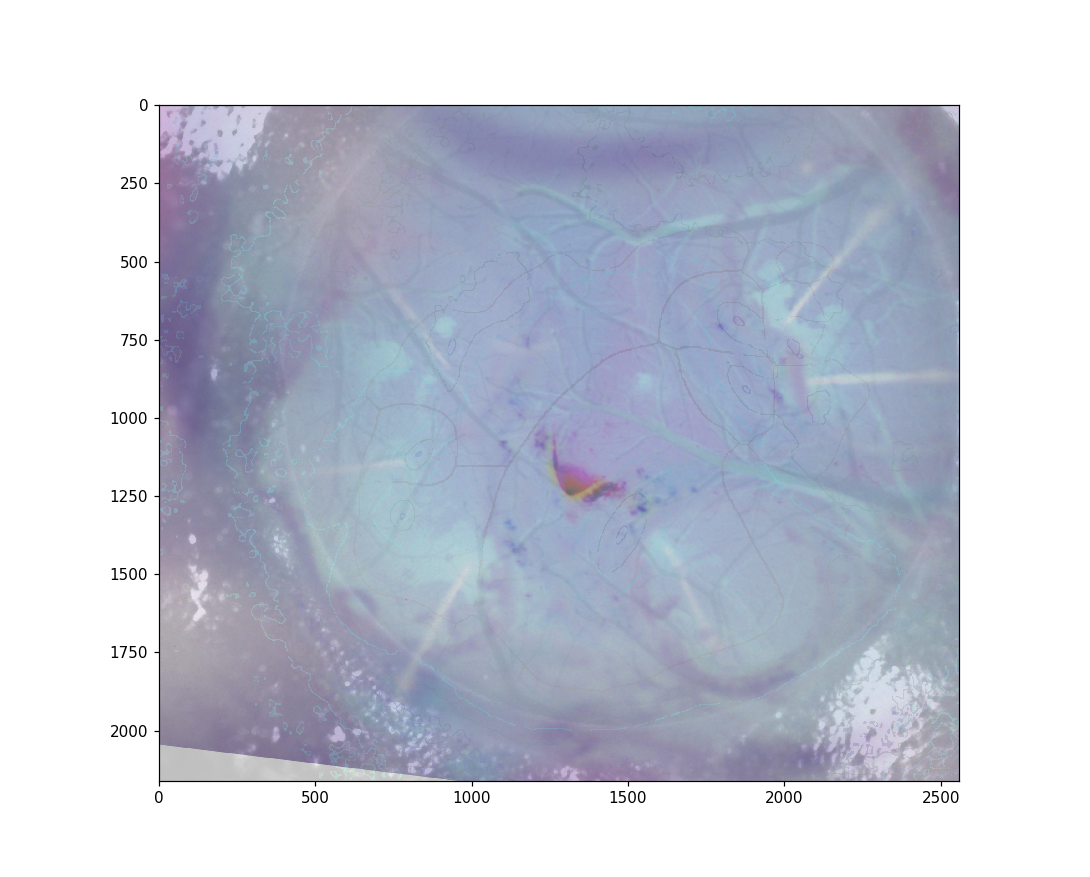

In [43]:
#Compute affine transform to warp probe insertion image to vasculature image coordinates

#reshape points into [numpoints, 2] arrays
ppoints = ppa.points #np.stack((ppa.xs, ppa.ys)).astype(np.float32).T
vpoints = vpa.points #np.stack((vpa.xs, vpa.ys)).astype(np.float32).T

#get perspective transform between images and apply it to probe insertion image
perspective = cv2.findHomography(ppoints, vpoints)
pimg_transform = cv2.warpPerspective(pimg, perspective[0], (vimg.shape[1], vimg.shape[0]))

#transform probe insertion points to use in local warping or plot on transformed image
ppoints_transform = cv2.perspectiveTransform(np.array([ppoints.astype(np.float32)]), perspective[0])
ppoints_transform = np.squeeze(ppoints_transform)

#perform Delaunay triangle local warp if specified
if localWarp:
    pimg_transform = warpImage.warpImage(vimg, pimg_transform, vpoints, ppoints_transform)

#plot overlay of vasculature image and transformed image to compare
overlay_fig, overlay_ax = plt.subplots(figsize=(10,10/aspect))
overlay_ax.imshow(vimg, alpha=0.5)
overlay_ax.imshow(255-pimg_transform, alpha=0.5)


<IPython.core.display.Javascript object>


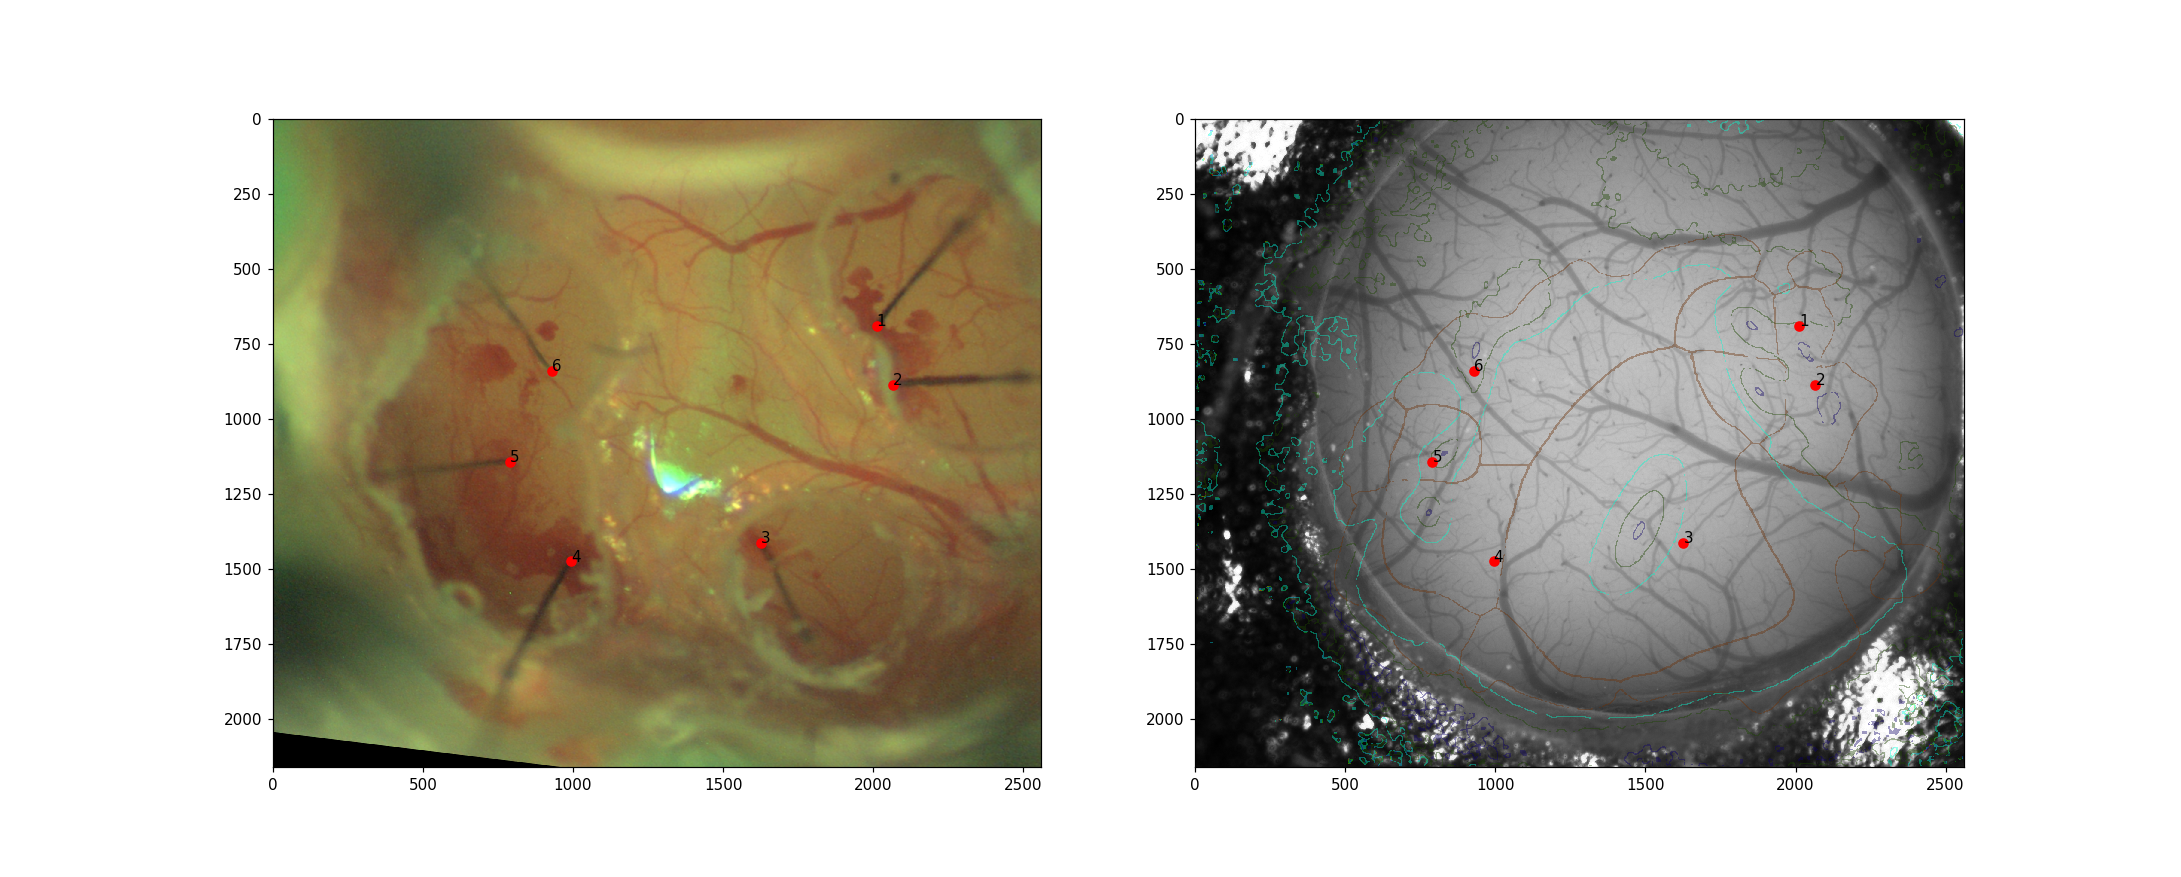

In [44]:
#Select location of probe insertion points in this warped image
insertion_location_fig, insertion_location_ax = plt.subplots(1,2, figsize=(20,20/(2*aspect)))
paffax = insertion_location_ax[0]
vax2 = insertion_location_ax[1]

paff_im = paffax.imshow(pimg_transform, origin='upper')
paffp = pointAnnotator(paff_im, paffax)
probe_insertion_points = points_from_path(pimg_path, chosen_vasculature_image_name, chosen_probe_image_name, 'insertion')
paffp.loadPoints(probe_insertion_points)

#paffpoints = paffp.points  # np.stack((paffp.xs, paffp.ys)).astype(np.float32).T


vim2 = vax2.imshow(vimg, origin='upper')
vpa = pointCopier(vim2, vax2, paffax)
vpa.loadPoints(probe_insertion_points)

In [45]:
print(paffp.points)
print(paffp.points[:, 0])

[[2011.714    690.38654]
 [2066.2173   886.59814]
 [1626.5579  1413.4626 ]
 [ 994.3205  1475.233  ]
 [ 790.8418  1144.5801 ]
 [ 928.9166   839.362  ]]
[2011.714  2066.2173 1626.5579  994.3205  790.8418  928.9166]


In [46]:
#####IMPORTANT#####
#please edit this list to reflect which areas the probes were inserted into

# your options are: 'VISam', 'VISpm', 'VISp', 'VISlm', 'VISal', 'VISrl', 'VIS'
#We should come up with a good indicator for border areas

area_list = ['VISmma', 'VISmmp', 'VISp', 'VISlm?', 'VIal', 'VISrl']

In [47]:
# save points and transformation matrix
save_path = cfg.get_save_path(pimg_path)#, mouse_num)
#save_path = os.path.join(r'C:\Users\severined\Allen\Neuropixels_Pipeline\probe_locator', mouse_num)
save_dir = os.path.split(save_path)[0]
if not(os.path.isdir(save_dir, )):
    os.mkdir(save_dir)
try:
    np_load_old = np.load
    # modify the default parameters of np.load
    np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)
    # call load_data with allow_pickle implicitly set to true
    current_npz = np.load(save_path)
    # restore np.load for future normal usage
    np.load = np_load_old
    #save_dict = {}
    #for thing in current_npz:
    #    print(thing)#, current_npz[thing]
    #    save_dict[thing]= current_npz[thing]
    save_dict = dict(current_npz, allow_pickle=True)
except (IOError, TypeError) as E:
    save_dict = {}

save_dict['vasculatureImageKeypoints'] = vpoints
save_dict['probeImageKeypoints'] = ppoints
save_dict['vasculatureToProbeInsertionTransform'] = perspective[0]
save_dict['probeInsertionPointsTransformed'] = paffp.points

if not('contributingInsertionImageNames' in save_dict):
    save_dict['contributingInsertionImageNames']=[{}]
contributingInsertionImageNames_dict = save_dict['contributingInsertionImageNames'][0]
    
this_image_pair = (chosen_probe_image_name, chosen_vasculature_image_name)
probe_list = ['A', 'B', 'C', 'D', 'E', 'F']
for probe in probe_list:
    if not(probe in contributingInsertionImageNames_dict):
        contributingInsertionImageNames_dict[probe] = []
    contributingInsertionImageNames_dict[probe].append(this_image_pair)

save_dict['contributingInsertionImageNames'][0] = contributingInsertionImageNames_dict

if not('probesFromImagePair' in save_dict):
    save_dict['probesFromImagePair']=[{}]
probesFromImagePair_dict = save_dict['probesFromImagePair'][0]
probesFromImagePair_dict[this_image_pair] = probe_list
save_dict['probesFromImagePair'][0] = probesFromImagePair_dict


if not('imagePairCoordinates' in save_dict):
    save_dict['imagePairCoordinates']=[{}]
imagePairCoordinates_dict = save_dict['imagePairCoordinates'][0]


imagePairCoordinates_dict[chosen_vasculature_image_name+'_landmark_points'] = vpoints
imagePairCoordinates_dict[chosen_probe_image_name+'_landmark_points'] = ppoints
imagePairCoordinates_dict[chosen_probe_image_name+'_to_'+chosen_vasculature_image_name+'_transform'] = perspective[0]
imagePairCoordinates_dict[chosen_probe_image_name+'_to_'+chosen_vasculature_image_name+'_insertion_points'] = paffp.points

save_dict['imagePairCoordinates'][0] = imagePairCoordinates_dict


session_name = cfg.get_session_name(pimg_path)

np.savez(save_path, **save_dict)

save_images_dict = {
    'insertionLocation':insertion_location_fig,
    'overlay':overlay_fig, 
    'fiducial':fiducial_fig
}
for name, fig in save_images_dict.items():
    image_path = os.path.join(save_dir, session_name+'.'+name+'.png')
    print(image_path)
    fig.savefig(image_path)

### SAVE TRANSFORMED PROBE IMAGE TO USE FOR DAY 2 ALIGNMENT IF NECESSARY
warped_save_path = os.path.join(save_dir, session_name+'.warpedInsertionImage.png')
print(warped_save_path)
cv2.imwrite(warped_save_path, pimg_transform)

column_list = [
    'Probe',
    'Area',
    'ISI Pixel Coordinate X',
    'ISI Pixel Coordinate Y',
    'Images Used'
]

csv_path = os.path.join(save_dir, session_name+'.areaClassifications.csv')
try:
    current_csv_df = pd.read_csv(csv_path,  index_col=False)
except IOError as E:
    current_csv_df = pd.DataFrame(columns=column_list)

current_csv_df.loc[:, 'Probe'] = probe_list
current_csv_df.loc[:, 'Area'] = area_list
current_csv_df.loc[:, 'ISI Pixel Coordinate X'] = paffp.points[:, 0]
current_csv_df.loc[:, 'ISI Pixel Coordinate Y'] = paffp.points[:, 1]
current_csv_df.loc[:, 'Images Used'] = [str(this_image_pair)]*6

current_csv_df.to_csv(csv_path, index=False)



\\w10DTSM112719\neuropixels_data\1012367144_495662_20200304\1012367144_495662_20200304.insertionLocation.png
\\w10DTSM112719\neuropixels_data\1012367144_495662_20200304\1012367144_495662_20200304.fiducial.png
\\w10DTSM112719\neuropixels_data\1012367144_495662_20200304\1012367144_495662_20200304.overlay.png


In [48]:
current_csv_df.head(6)


Probe    Area  ISI Pixel Coordinate X  ISI Pixel Coordinate Y  \
0     A  VISmma             2011.713989              690.386536   
1     B  VISmmp             2066.217285              886.598145   
2     C    VISp             1626.557861             1413.462646   
3     D  VISlm?              994.320496             1475.233032   
4     E    VIal              790.841797             1144.580078   
5     F   VISrl              928.916626              839.362000   

                                         Images Used  
0  ('1012367144_495662_20200304_surface-image3-ri...  
1  ('1012367144_495662_20200304_surface-image3-ri...  
2  ('1012367144_495662_20200304_surface-image3-ri...  
3  ('1012367144_495662_20200304_surface-image3-ri...  
4  ('1012367144_495662_20200304_surface-image3-ri...  
5  ('1012367144_495662_20200304_surface-image3-ri...

In [49]:
# save notebook as html
saveDirectory = os.path.dirname(pimg_path)
os.system('jupyter nbconvert probeInsertionLocator.ipynb --output ' + os.path.join(saveDirectory, 'probeInsertionNotebook.html'))

0